#Final Project: Stock Market Predictions
####Biel Alcaraz, Jordi Comellas & María Tormo

In [162]:
#Libraries and settings

import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

<ipython-input-162-dca9776a94c8>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-162-dca9776a94c8>:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


##Mount our Google Drive within the Colab Notebook and create a function to load the data  and select the desired columns from the dataset (CSV files)

In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
#Load Data
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv('/content/drive/My Drive/DeepLearning_2023/FinalProject/input/{}.csv'.format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

##Plot Stock markets from *initial_date = 19/08/2004* to *end_date = 13/05/2022* of three selected companies: Google, Netflix and Apple separately.

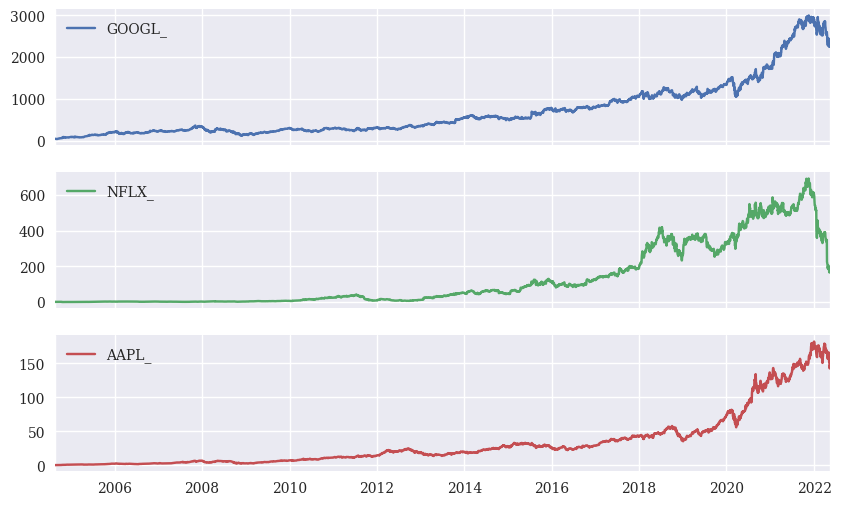

In [165]:
#dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
dates = pd.date_range('2004-08-19','2022-05-13',freq='B') #all business days between start & end date of datasets (common)
symbols = ['GOOGL_','NFLX_','AAPL_']
df = stocks_data(symbols, dates)
df = df.fillna(method='pad') #fill missing values using pad method (fill values with last observed value)
df.plot(figsize=(10, 6), subplots=True);

In [166]:
#Show first 5 values
df.head()

,GOOGL_,NFLX_,AAPL_
2004-08-19,50.220219,2.264286,0.548393
2004-08-20,54.209209,2.262857,0.550000
2004-08-23,54.754753,2.272857,0.555000
2004-08-24,52.487488,2.208571,0.570536
2004-08-25,53.053055,2.238571,0.590179


In [167]:
den_df = pd.DataFrame(index=dates)
den_df = df
#display(den_df)

scaler = MinMaxScaler(feature_range=(-1, 1))
df['GOOGL_'] = scaler.fit_transform(df['AAPL_'].values.reshape(-1,1))
df['NFLX_'] = scaler.fit_transform(df['AAPL_'].values.reshape(-1,1))
df['AAPL_'] = scaler.fit_transform(df['AAPL_'].values.reshape(-1,1))


##Plot Google stock price values from *initial_date = 02/01/2010* to *end_date = 11/10/2017* (specify)

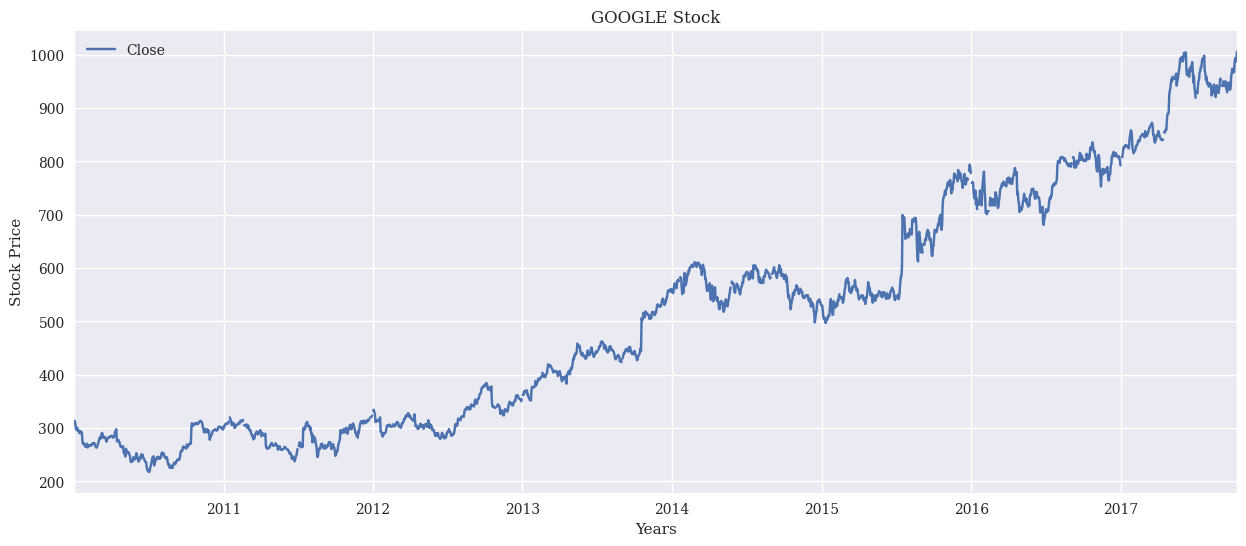

In [168]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
#dates = pd.date_range('2015-05-13','2022-05-13',freq='B')
df1 = pd.DataFrame(index=dates)
df_google = pd.read_csv("/content/drive/My Drive/DeepLearning_2023/FinalProject/input/GOOGL_.csv", parse_dates=True, index_col=0)
df_google = df1.join(df_google)
df_google[['Close']].plot(figsize=(15, 6))
plt.xlabel("Years")
plt.ylabel("Stock Price")
plt.title("GOOGLE Stock")
plt.show()

In [169]:
#Info about google close column values
df_google = df_google[['Close']]
df_google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 96.2 KB


In [170]:
#Fill missing values with the preceding non-null value using forward filling (ffill)
df_google = df_google.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_google['Close'] = scaler.fit_transform(df_google['Close'].values.reshape(-1,1))
#df_google

In [171]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 30 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_google, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (1598, 29, 1)
y_train.shape =  (1598, 1)
x_test.shape =  (400, 29, 1)
y_test.shape =  (400, 1)


In [172]:
# Make Training and Testing sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [173]:
y_train.size(),x_train.size()

(torch.Size([1598, 1]), torch.Size([1598, 29, 1]))

##Build the Structure of the model (LSTM Model)

In [174]:
# Build model
#####################
input_dim = 1
#hidden_dim = 32
hidden_dim = 64
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10

        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
10
torch.Size([256, 1])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([1, 64])
torch.Size([1])


##Training and Testing of the implemented Model

In [175]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.0694674402475357
Epoch  20 MSE:  0.013098775409162045
Epoch  30 MSE:  0.0062743001617491245
Epoch  40 MSE:  0.001902290852740407
Epoch  50 MSE:  0.001268974388949573
Epoch  60 MSE:  0.0011592156952247024
Epoch  70 MSE:  0.0009907203493639827
Epoch  80 MSE:  0.0008964595035649836
Epoch  90 MSE:  0.0008329551201313734
Epoch  100 MSE:  0.0007870706031098962
Epoch  110 MSE:  0.0007506426773034036
Epoch  120 MSE:  0.0007272702641785145
Epoch  130 MSE:  0.0007120160735212266
Epoch  140 MSE:  0.0006985398940742016
Epoch  150 MSE:  0.0006850958452560008
Epoch  160 MSE:  0.0006711763562634587
Epoch  170 MSE:  0.0006588613032363355
Epoch  180 MSE:  0.0006489412044174969
Epoch  190 MSE:  0.0006397683755494654


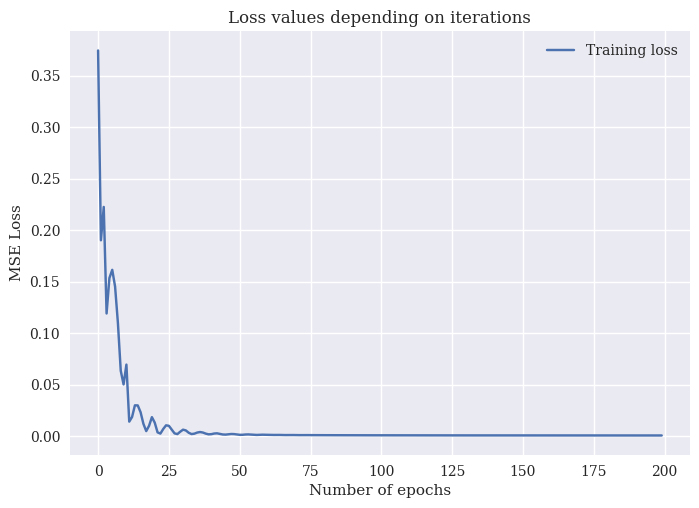

In [176]:
plt.plot(hist, label="Training loss")
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title("Loss values depending on iterations")
plt.legend()
plt.show()

In [177]:
np.shape(y_train_pred)

torch.Size([1598, 1])

In [178]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.90 RMSE
Test Score: 30.19 RMSE


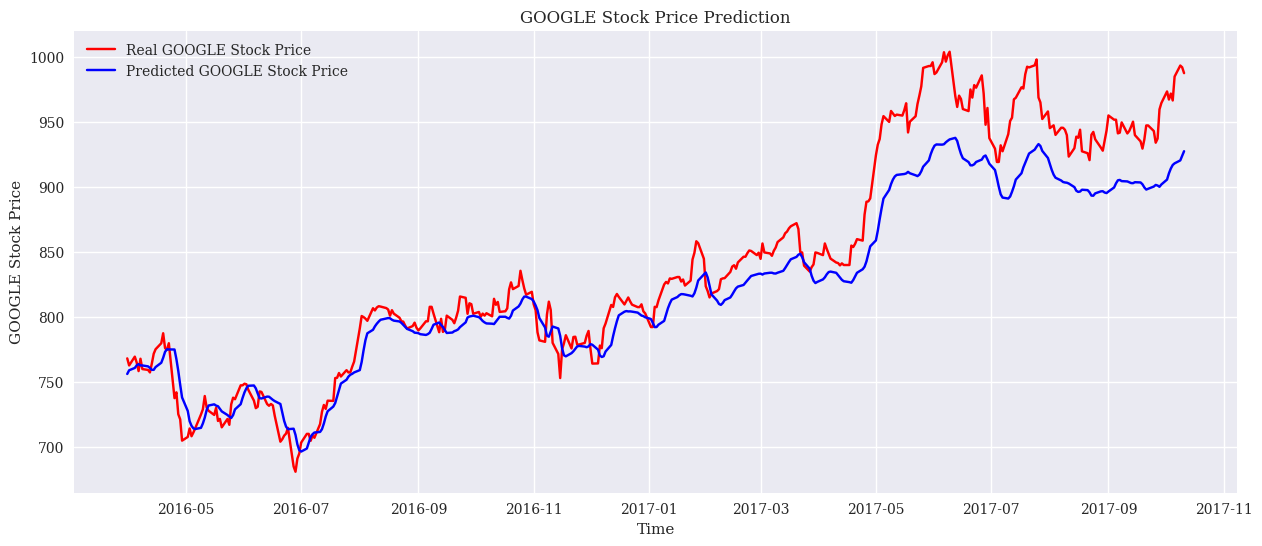

In [179]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_google[len(df_google)-len(y_test):].index, y_test, color = 'red', label = 'Real GOOGLE Stock Price')
axes.plot(df_google[len(df_google)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted GOOGLE Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('GOOGLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGLE Stock Price')
plt.legend()
plt.savefig('google_pred.png')
plt.show()

## Now we will input the stock prices of other companies

In [180]:
def new_load_data(stocks, look_back, train_ratio=0.8):
    data_raw = stocks.values
    data = []
    labels = []

    for index in range(len(data_raw) - look_back):
      data.append(data_raw[index : index + look_back])
      labels.append(data_raw[index + look_back])

    data = np.array(data)
    labels = np.array(labels)

    test_set_size = int(np.round((1-train_ratio) * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train, x_test = data[:train_set_size], data[train_set_size:]
    y_train, y_test = labels[:train_set_size], labels[train_set_size:]
    return [x_train, y_train, x_test, y_test]

In [181]:
# Load additional stock data
df_netflix = pd.read_csv("/content/drive/My Drive/DeepLearning_2023/FinalProject/input/NFLX_.csv", parse_dates=True, index_col=0)
df_apple = pd.read_csv("/content/drive/My Drive/DeepLearning_2023/FinalProject/input/AAPL_.csv", parse_dates=True, index_col=0)
# ... Load data for other companies ...

# Join the additional stock data with df2 and df3 (dataframes with selected dates)
df2 = pd.DataFrame(index=dates)
df3 = pd.DataFrame(index=dates)
df_netflix = df2.join(df_netflix, rsuffix='_Netflix')
df_apple = df3.join(df_apple, rsuffix='_Apple')
# ... Join data for other companies ...

# Fill missing values and apply scaling as before
df_google = df_google.fillna(method='ffill')
df_netflix = df_netflix.fillna(method='ffill')
df_apple = df_apple.fillna(method='ffill')

# Prepare the data for training and testing
stocks = [df_google['Close'], df_netflix['Close'], df_apple['Close']]
x_train, y_train, x_test, y_test = new_load_data(df, look_back)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

# Convert to torch tensors as before
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


x_train.shape =  (3678, 30, 3)
y_train.shape =  (3678, 3)
x_test.shape =  (919, 30, 3)
y_test.shape =  (919, 3)


In [182]:
hidden_dim = 64
num_layers = 2

class NewLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(NewLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = out[:, -1, :]
        out = out.view(batch_size, -1)
        out = self.fc(out)

        return out


model = NewLSTM(input_dim=len(stocks), hidden_dim=hidden_dim, num_layers=num_layers, output_dim=len(stocks))

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

NewLSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
10
torch.Size([256, 3])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([3, 64])
torch.Size([3])


In [183]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


Epoch  10 MSE:  0.07736480981111526
Epoch  20 MSE:  0.026957152411341667
Epoch  30 MSE:  0.023587990552186966
Epoch  40 MSE:  0.021227823570370674
Epoch  50 MSE:  0.015845850110054016
Epoch  60 MSE:  0.004482839722186327
Epoch  70 MSE:  0.00209339102730155
Epoch  80 MSE:  0.0010731584625318646
Epoch  90 MSE:  0.0003832997754216194


##**Plot of the MSE**

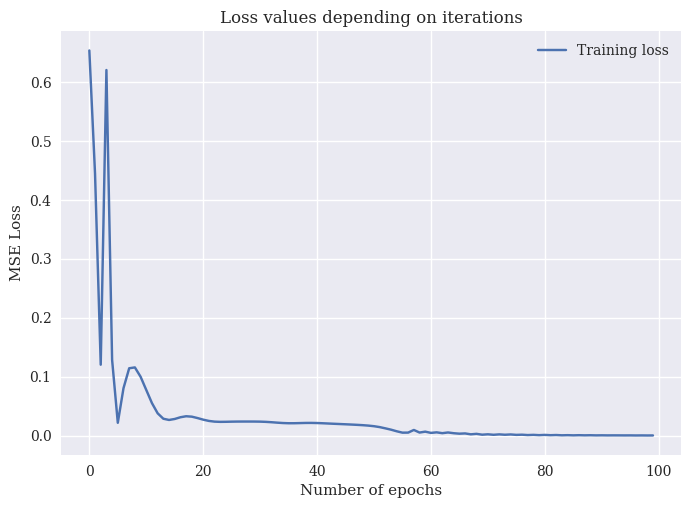

In [184]:
plt.plot(hist, label="Training loss")
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title("Loss values depending on iterations")
plt.legend()
plt.show()

In [185]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.68 RMSE
Test Score: 239.58 RMSE


#**Plots of 3 stocks Real Values (TRAIN and TEST)**

##Whole Stock Prices (Google, Netflix and Apple)

In [186]:
# Retrieve the dates for the testing period from the original DataFrame df
testing_dates = df.index[-len(y_train):]
print(testing_dates)
# Create a new DataFrame y_test_pred_with_dates with the denormalized values of y_test_pred and the corresponding testing dates
#y_test_pred_with_dates = pd.DataFrame(data=y_test_pred_denorm, index=testing_dates, columns=symbols)

DatetimeIndex(['2008-04-09', '2008-04-10', '2008-04-11', '2008-04-14',
               '2008-04-15', '2008-04-16', '2008-04-17', '2008-04-18',
               '2008-04-21', '2008-04-22',
               ...
               '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05',
               '2022-05-06', '2022-05-09', '2022-05-10', '2022-05-11',
               '2022-05-12', '2022-05-13'],
              dtype='datetime64[ns]', length=3678, freq='B')


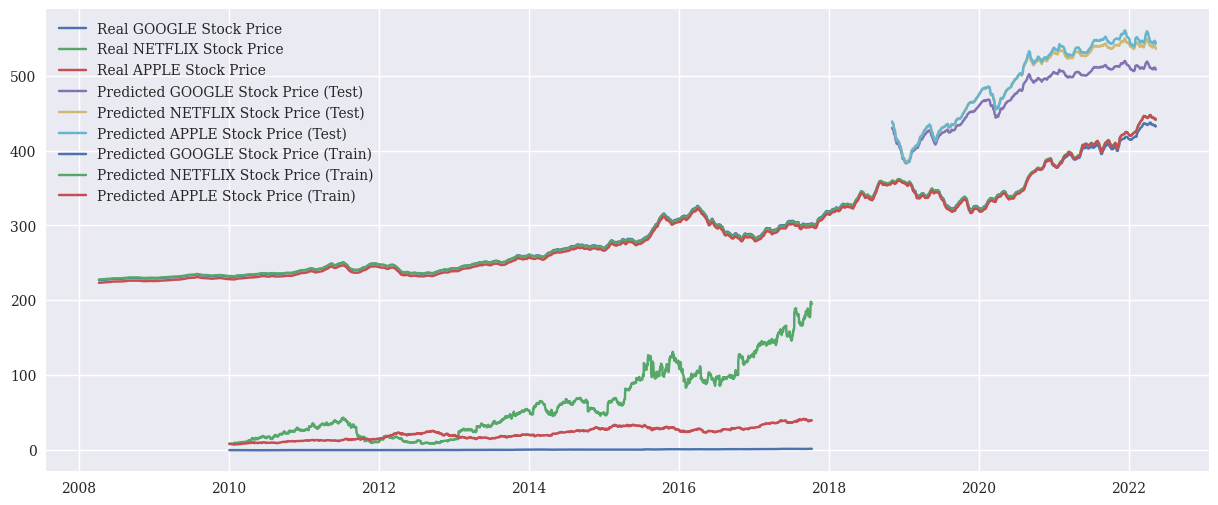

In [187]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

# Plot the 'Close' column from df_google with a specific color and label
axes.plot(df_google['Close'], label='Real GOOGLE Stock Price')
axes.plot(df_netflix['Close'], label='Real NETFLIX Stock Price')
axes.plot(df_apple['Close'], label='Real APPLE Stock Price')

#Plot Test Predictions
axes.plot(df.index[-len(y_test):], y_test_pred[:, 0], label='Predicted GOOGLE Stock Price (Test)')
axes.plot(df.index[-len(y_test):], y_test_pred[:, 1], label='Predicted NETFLIX Stock Price (Test)')
axes.plot(df.index[-len(y_test):], y_test_pred[:, 2], label='Predicted APPLE Stock Price (Test)')

#Plot Train Predictions
axes.plot(df.index[-len(y_train):], y_train_pred[:, 0], label='Predicted GOOGLE Stock Price (Train)')
axes.plot(df.index[-len(y_train):], y_train_pred[:, 1], label='Predicted NETFLIX Stock Price (Train)')
axes.plot(df.index[-len(y_train):], y_train_pred[:, 2], label='Predicted APPLE Stock Price (Train)')

# Add a legend
#axes.legend(['Real GOOGLE Stock Price', 'Real NETFLIX Stock Price', 'Real APPLE Stock Price'])
axes.legend()


# Display the plot
plt.show()

##**TRAIN**


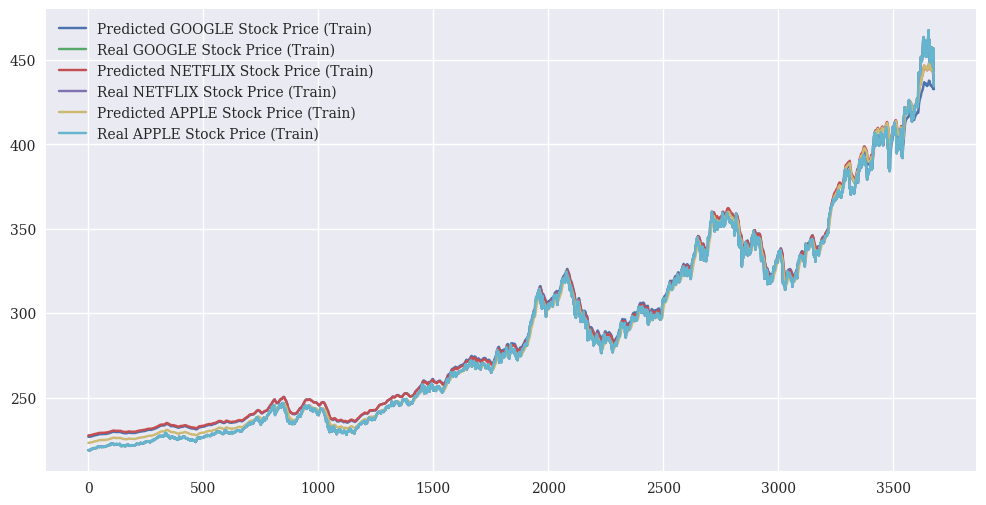

In [188]:
plt.figure(figsize=(12, 6))

plt.plot(y_train_pred[:, 0], label='Predicted GOOGLE Stock Price (Train)')
plt.plot(y_train[:, 0], label='Real GOOGLE Stock Price (Train)')

plt.plot(y_train_pred[:, 1], label='Predicted NETFLIX Stock Price (Train)')
plt.plot(y_train[:, 1], label='Real NETFLIX Stock Price (Train)')

plt.plot(y_train_pred[:, 2], label='Predicted APPLE Stock Price (Train)')
plt.plot(y_train[:, 2], label='Real APPLE Stock Price (Train)')

plt.legend()

##**TEST**

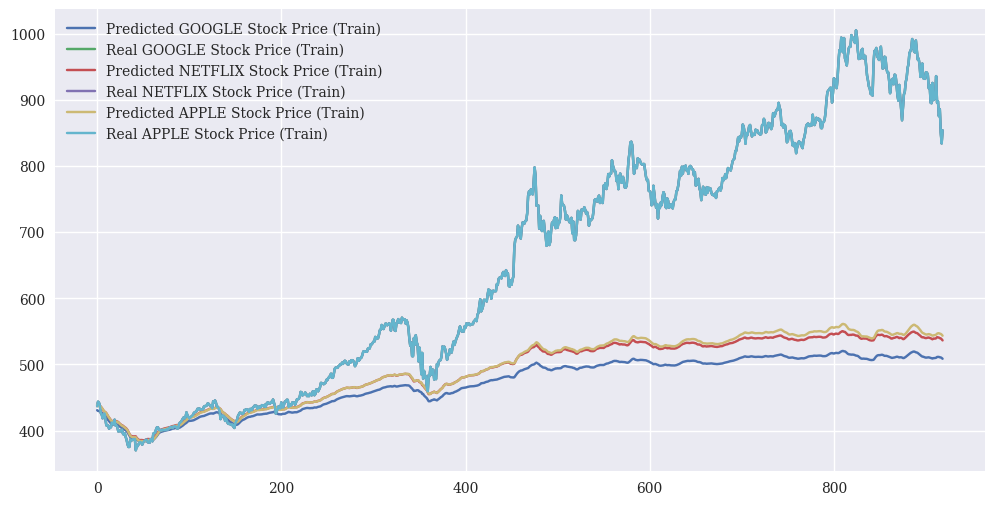

In [189]:
plt.figure(figsize=(12, 6))

plt.plot(y_test_pred[:, 0], label='Predicted GOOGLE Stock Price (Train)')
plt.plot(y_test[:, 0], label='Real GOOGLE Stock Price (Train)')

plt.plot(y_test_pred[:, 1], label='Predicted NETFLIX Stock Price (Train)')
plt.plot(y_test[:, 1], label='Real NETFLIX Stock Price (Train)')

plt.plot(y_test_pred[:, 2], label='Predicted APPLE Stock Price (Train)')
plt.plot(y_test[:, 2], label='Real APPLE Stock Price (Train)')

plt.legend()